In [ ]:
#import ydata_profiling
import pandas as pd
import numpy as np
import re
from types import ModuleType

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10,5)

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

import seaborn as sns

!pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyClassifier



In [ ]:
#importer les 2 base de données dans un df pandas et afficher les 5 premières lignes
# ici on voudra prédir si le passager a survecu ou non

url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
titanic = pd.read_csv(url)
titanic.drop('PassengerId', axis=1, inplace=True)


titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [ ]:
#ici on voudra prédir si le patient a eu un AVC
url2 = 'https://raw.githubusercontent.com/Devashree21/stroke-prediction-machine-learning/main/healthcare-dataset-stroke-data.csv'
brain = pd.read_csv(url2)
brain.drop('id', axis=1, inplace=True)
brain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [ ]:
# Premier nettoyage de la base
# On compte les NaN dans chaque colonne, si + de 20%, on supprime la colonne, si -, on impute la moyenne

def clean_NaN(df):
    colonnes_suppr = []
    lignes_suppr = []
    for column in df.columns:
        proportion_NaN = df[column].isna().mean()
        if proportion_NaN > 0.2:
            df.drop(column, axis=1, inplace=True)
            print(f"La ou les colonnes '{column}' ont été supprimés")

In [ ]:
#fonction date qu'on utilise apres dans la fonction qui detecte le type de variable
def is_date(value):
    # Liste de regex pour les formats de dates les plus connus
    date_regex_patterns = [
        r'\d{4}-\d{2}-\d{2}',
        r'\d{2}-\d{2}-\d{4}',
        r'\d{1,2}/\d{1,2}/\d{4}',
        r'\d{1,2}/\d{1,2}/\d{2}',
        r'\d{4}/\d{2}/\d{2}',
        r'\d{2}/\d{2}/\d{4}',
        r'\d{1,2}\s[a-zA-Z]{3,}\s\d{4}',
        r'[a-zA-Z]{3,}\s\d{1,2},\s\d{4}',
        r'[a-zA-Z]{3,}\s\d{1,2}\s\d{4}',
        r'\d{1,2}\s[a-zA-Z]{3,}\s\d{2}',
        r'[a-zA-Z]{3,}\s\d{1,2},\s\d{2}',
        r'[a-zA-Z]{3,}\s\d{1,2}\s\d{2}'
    ]

    for pattern in date_regex_patterns:
        if re.match(pattern, str(value)):
            return True
    return False

In [ ]:
#fonction qui détecte automatiquement le type de variable d'une colonne
def get_column_variable_type(column):
  if column.nunique() < 11:
    return 'category'
  elif column.apply(is_date).all() == True:
    return 'datetime'
  elif column.apply(lambda x: isinstance(x, str)).all() == True:
    return 'str'
  elif column.apply(lambda x: isinstance(x, float)).all() == True:
    return 'float'
  elif column.apply(lambda x: isinstance(x, int)).all() == True:
    return 'int'
  else:
    return 'str'

In [ ]:
#fonction pour récupérer les types de variables de touts nos colonnes dans l'ordre
def data_type_columns(data: pd.DataFrame):
    type_var_colonnes = []
    for column in data.columns:
        type_var_colonnes.append(get_column_variable_type(data[column]))
    return type_var_colonnes

In [ ]:
# TEST UNITAIRE DE get_column_variable_type()
# on utilise un dataset écrit en dure créer spécifiquement pour tester toutes les sorties possibles de la fonction get_column_variable_type()
# on a aussi une listes avec les réponses attendues sur notre dataset de test
# finalement on compare les deux listes pour voir si elles sont égales
# si toutes les sorties sont corrects, ont considère que notre fonction est bonne, sinon, on raise une erreure, notre fonction bug

data = {
    'bool_column': [True, False, True, False, True, False, True, False, True, False, True],
    'category_column': ['A', 'B', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'date_column': pd.date_range('2023-01-01', periods=11),
    'str_column': ['apple', 'banana', 'orange', 'pear', 'grape', 'pineapple', 'lemon', 'melon', 'peach', 'plum', 'kiwi'],
    'float_column': [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9, 10.1, 11.11],
    'int_column': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'else_column' : [2, 'B', 'zigzag', True, 3, 4, 5, 6, 7, 8, 9]
}

data_test_unitaire = pd.DataFrame(data)
data_type_attendues = ['category', 'category', 'datetime', 'str', 'float', 'int', 'str']

def test_unitaire(data_test_unitaire, data_type_attendues):
    if data_type_columns(data_test_unitaire) != data_type_attendues:
        raise ValueError("Il y a un problème, la fonction data_type_columns() ne retourne pas les bons résultats")
    else:
        print("Test unitaire validé")

In [ ]:
test_unitaire(data_test_unitaire, data_type_attendues)

Test unitaire validé


In [ ]:
#fonction pour appliquer les bonnes catégories à nos variables
def change_dtypes(df, data_types):
    for column, dtype in zip(df.columns, data_types):
        df[column] = df[column].astype(dtype)

In [ ]:
#fonction pour supprimer les colonnes de type 'object', c'est celle qu'on a pas réussi à classifier
def remove_object_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    df.drop(columns=object_columns, inplace=True)

In [ ]:
# creer la pipeline de preprocessing
def pre_process_pipeline():
  numerical_features = make_column_selector(dtype_include=np.number)
  categorical_features = make_column_selector(dtype_include= 'category')
  bool_features = make_column_selector(dtype_include= 'bool')

  numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                                                 StandardScaler())
  categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                 OneHotEncoder())

  preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                   (categorical_pipeline, categorical_features))
  #model = make_pipeline(preprocessor, LazyClassifier(verbose=0)))

  #df_preprocessed = preprocessor.fit_transform()

  return preprocessor



Après avoir déclaré toutes nos fonction, on les éxecutes sur nos 2 bases

In [ ]:
#ici on commence par appliquer notre fonction de nettoyage
clean_NaN(titanic)

La ou les colonnes 'Cabin' ont été supprimés


In [ ]:
clean_NaN(brain)

In [ ]:
#ensuite on applique les bons datatype a nos variables
change_dtypes(titanic, data_type_columns(titanic))

In [ ]:
change_dtypes(brain, data_type_columns(brain))

In [ ]:
# puis on supprime les colonnes 'object'
remove_object_columns(titanic)

In [ ]:
remove_object_columns(brain)

In [ ]:
titanic.dtypes

Survived    category
Pclass      category
Sex         category
Age          float64
SibSp       category
Parch       category
Fare         float64
Embarked    category
dtype: object

In [ ]:
brain.dtypes

gender               category
age                   float64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke               category
dtype: object

In [ ]:
print(titanic.shape)
print(brain.shape)

(891, 8)
(5110, 11)


In [ ]:
#On utilise la bibliothèque lazypredict pour voir quels modèles ont les meilleurs performances sur le data set de base
#on sépare nos données entre jeu de test et jeu d'entrainement

y = titanic['Survived']
X = titanic.drop('Survived', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     random_state=12,
                     classifiers='all',
                    )
models_titanic, predictions_titanics = clf.fit(X_train, X_test, y_train, y_test)
models_titanic

100%|██████████| 29/29 [00:02<00:00,  9.95it/s]


[LightGBM] [Info] Number of positive: 258, number of negative: 410
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386228 -> initscore=-0.463198
[LightGBM] [Info] Start training from score -0.463198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.74,0.72,0.72,0.74,0.56
SVC,0.75,0.69,0.69,0.73,0.05
ExtraTreesClassifier,0.70,0.68,0.68,0.70,0.34
LGBMClassifier,0.71,0.67,0.67,0.70,0.11
ExtraTreeClassifier,0.69,0.67,0.67,0.69,0.03
XGBClassifier,0.70,0.66,0.66,0.69,0.08
AdaBoostClassifier,0.73,0.66,0.66,0.70,0.23
NearestCentroid,0.71,0.66,0.66,0.70,0.03
DecisionTreeClassifier,0.68,0.66,0.66,0.68,0.04


In [ ]:
model_titanic = LazyClassifier(predictions=True)

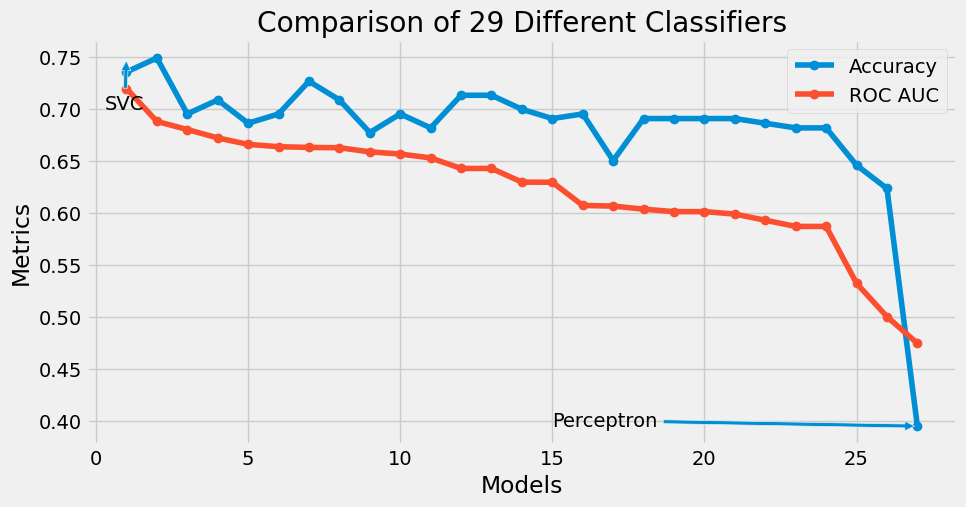

In [ ]:
idx = [i for i in range(1,28)]
plt.plot(idx, models_titanic["Accuracy"]  ,marker='o' , label = "Accuracy" )
plt.plot(idx , models_titanic["ROC AUC"] , marker ='o' , label = "ROC AUC")
plt.annotate(models_titanic.index[1] ,
             (1,models_titanic["Accuracy"][1]) ,
             xytext  =(0.3, 00.7),
             arrowprops = dict(
                               arrowstyle = "simple"
                              ))
plt.annotate(models_titanic.index[26] ,
             (27 , models_titanic["Accuracy"][26]) ,
             xytext  =(15, models_titanic["Accuracy"][26]),
             arrowprops = dict(
                               arrowstyle = "simple"
                              ))
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.title("Comparison of 29 Different Classifiers")
plt.legend()
plt.show()

In [ ]:
# comme on l'a vu la RandomForest semble très bien fonctionné sur ce dataset
#Utilisons maintenant ce modele sur notre jeu de données pre processer

In [ ]:
#normalisation des donnees
#maintenant on utilise notre pipeline pour preprocess nos dataset
titanic_preprocessor = pre_process_pipeline()

In [ ]:
model_RF_titanic = make_pipeline(titanic_preprocessor, RandomForestClassifier(random_state=0))

In [ ]:
model_RF_titanic.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e9fbd60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e9fbfd0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [ ]:
score = model_RF_titanic.score(X_test, y_test)
score

0.8251121076233184

In [ ]:
pipe_params = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
}



gridsearch = GridSearchCV(
    model_RF_titanic, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=1000
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e9fbd60>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e9fbfd0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 10, 20,
                                                               30],
                         'randomforestclassifier__n_estimators': [100, 200,
                                                                  300]},
             verbose=1000)

In [ ]:
best_hyperparameters = gridsearch.best_params_
print("Best hyperparameters:", best_hyperparameters)
best_score = gridsearch.best_score_
print("Best cross-validation score:", best_score)

Best hyperparameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100}
Best cross-validation score: nan


In [ ]:
results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.66,0.07,0.02,0.01,None,100,"{'randomforestclassifier__max_depth': None, 'r...",NaN,0.79,0.78,NaN,NaN,1
1,1.33,0.14,0.07,0.02,None,200,"{'randomforestclassifier__max_depth': None, 'r...",NaN,0.79,0.79,NaN,NaN,1
2,2.15,0.42,0.18,0.12,None,300,"{'randomforestclassifier__max_depth': None, 'r...",NaN,0.78,0.78,NaN,NaN,1
3,1.24,0.02,0.09,0.03,10,100,"{'randomforestclassifier__max_depth': 10, 'ran...",NaN,0.80,0.80,NaN,NaN,1
4,1.27,0.19,0.05,0.02,10,200,"{'randomforestclassifier__max_depth': 10, 'ran...",NaN,0.81,0.81,NaN,NaN,1


In [ ]:
score_gridsearch = gridsearch.score(X_test, y_test)
score_gridsearch

0.8251121076233184

In [ ]:
#Ici on calcule un intervalle de confiance de la précision de notre modele
X_test = pd.DataFrame(X_test)

# Reset the index of X_test to ensure it starts from 0
X_test.reset_index(drop=True, inplace=True)

# Define the number of bootstrap iterations
n_bootstraps = 1000

# Initialize an array to store accuracy scores from each bootstrap iteration
bootstrap_scores = np.zeros(n_bootstraps)

# Perform bootstrapping
for i in range(n_bootstraps):
    # Generate a bootstrap sample (with replacement) from the test set
    bootstrap_indices = np.random.choice(len(X_test), size=len(X_test), replace=True)
    X_bootstrap = X_test.iloc[bootstrap_indices]
    y_bootstrap = y_test.iloc[bootstrap_indices]

    # Evaluate the model on the bootstrap sample and compute accuracy
    score = gridsearch.score(X_bootstrap, y_bootstrap)

    # Store the accuracy score
    bootstrap_scores[i] = score

# Calculate the confidence interval
confidence_interval = np.percentile(bootstrap_scores, [2.5, 97.5])

# Print the confidence interval
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(confidence_interval[0], confidence_interval[1]))


95% Confidence Interval for Accuracy: [0.7758, 0.8789]


In [ ]:
#Apres avoir calculé l'intervalle de confiance, si celui ci est élevé (>10%), on affiche que le probleme est complexe,
# sinon qu'il est facile
interval_diff = confidence_interval[1] - confidence_interval[0]

seuil = 0.1 * (confidence_interval[1] + confidence_interval[0]) / 2

if interval_diff < seuil:
    print("Le probleme est facile")
else:
    print("Le probleme est dur")

Le probleme est dur


In [ ]:
# bien que le probleme soit dur, on a réussi à améliorer notre modele
# On a pu gagner 10 points d'accuracy en optimisant les hyperparamètres
# par rapport au modele avec hyperparametres par defaut de lazypredict

In [ ]:
#On reutilise la bibliothèque lazypredict sur la base brain
#on sépare nos données entre jeu de test et jeu d'entrainement

y = brain['stroke']
X = brain.drop('stroke', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     random_state=12,
                     classifiers='all',
                    )
models_brain, predictions_brain = clf.fit(X_train, X_test, y_train, y_test)
models_brain

100%|██████████| 29/29 [00:04<00:00,  7.22it/s]

[LightGBM] [Info] Number of positive: 184, number of negative: 3648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 3832, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048017 -> initscore=-2.986999
[LightGBM] [Info] Start training from score -2.986999


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.73,0.75,0.75,0.81,0.02
GaussianNB,0.92,0.59,0.59,0.92,0.02
QuadraticDiscriminantAnalysis,0.93,0.56,0.56,0.93,0.02
PassiveAggressiveClassifier,0.92,0.55,0.55,0.92,0.04
ExtraTreeClassifier,0.92,0.54,0.54,0.92,0.02
DecisionTreeClassifier,0.91,0.53,0.53,0.91,0.03
BaggingClassifier,0.95,0.53,0.53,0.93,0.09
XGBClassifier,0.95,0.53,0.53,0.93,0.11
LGBMClassifier,0.95,0.52,0.52,0.93,0.11


In [ ]:
model_brain = LazyClassifier(predictions=True)

In [ ]:
# Le modele des KNN semble tres bien fonctionné avec une Accuracy de 95%
#Utilisons maintenant ce modele sur notre jeu de données pre processer

In [ ]:
#normalisation des donnees
#maintenant on utilise notre pipeline pour preprocess nos dataset
brain_preprocessor = pre_process_pipeline()

In [ ]:
model_KNN_brain = make_pipeline(brain_preprocessor, KNeighborsClassifier())

In [ ]:
model_KNN_brain.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e9361d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e936620>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
score = model_KNN_brain.score(X_test, y_test)
score

0.9460093896713615

In [ ]:
pipe_params = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}



gridsearch = GridSearchCV(
    model_KNN_brain, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=1000
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e9361d0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7aa65e936620>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             verbose=1000)

In [ ]:
best_hyperparameters = gridsearch.best_params_
print("Best hyperparameters:", best_hyperparameters)
best_score = gridsearch.best_score_
print("Best cross-validation score:", best_score)

Best hyperparameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform'}
Best cross-validation score: nan


In [ ]:
results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.05,0.01,0.14,0.09,3,uniform,"{'kneighborsclassifier__n_neighbors': 3, 'knei...",0.94,0.94,NaN,NaN,NaN,1
1,0.04,0.00,0.04,0.02,3,distance,"{'kneighborsclassifier__n_neighbors': 3, 'knei...",0.94,0.94,NaN,NaN,NaN,1
2,0.04,0.00,0.11,0.07,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.95,0.95,NaN,NaN,NaN,1
3,0.05,0.01,0.05,0.03,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.95,0.94,NaN,NaN,NaN,1
4,0.04,0.00,0.11,0.06,7,uniform,"{'kneighborsclassifier__n_neighbors': 7, 'knei...",0.95,0.95,NaN,NaN,NaN,1


In [ ]:
score_KNN = gridsearch.score(X_test, y_test)
score_KNN

0.9428794992175273

In [ ]:
#Ici on calcule un intervalle de confiance de la précision de notre modele
X_test = pd.DataFrame(X_test)

# Reset the index of X_test to ensure it starts from 0
X_test.reset_index(drop=True, inplace=True)

# Define the number of bootstrap iterations
n_bootstraps = 1000

# Initialize an array to store accuracy scores from each bootstrap iteration
bootstrap_scores = np.zeros(n_bootstraps)

# Perform bootstrapping
for i in range(n_bootstraps):
    # Generate a bootstrap sample (with replacement) from the test set
    bootstrap_indices = np.random.choice(len(X_test), size=len(X_test), replace=True)
    X_bootstrap = X_test.iloc[bootstrap_indices]
    y_bootstrap = y_test.iloc[bootstrap_indices]

    # Evaluate the model on the bootstrap sample and compute accuracy
    score = gridsearch.score(X_bootstrap, y_bootstrap)

    # Store the accuracy score
    bootstrap_scores[i] = score

# Calculate the confidence interval
confidence_interval = np.percentile(bootstrap_scores, [2.5, 97.5])

# Print the confidence interval
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(confidence_interval[0], confidence_interval[1]))


95% Confidence Interval for Accuracy: [0.9296, 0.9546]


In [ ]:
#Apres avoir calculé l'intervalle de confiance, si celui ci est élevé (>10%), on affiche que le probleme est complexe,
# sinon qu'il est facile
interval_diff = confidence_interval[1] - confidence_interval[0]

seuil = 0.1 * (confidence_interval[1] + confidence_interval[0]) / 2

if interval_diff < seuil:
    print("Le probleme est facile")
else:
    print("Le probleme est dur")

Le probleme est facile


In [ ]:
#Nous n'avons pas pu améliorer la précision qui était deja très eleve, il faudrait s'intéresser au niveau du Balanced Accuracy